In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos
df_eth = pd.read_csv("Database/eth_final.csv")

# 🔹 Convertir fechas a datetime
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

# 🔹 Imputación de valores faltantes
tech_indicators = ['ETH_EMA_20', 'ETH_RSI', 'ETH_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_eth['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_eth[(df_eth['Date'] >= start_date) & (df_eth['Date'] < end_date)]

# Rellenar indicadores técnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_eth.loc[:, col] = df_eth[col].fillna(mean_value)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_eth.loc[:, 'Fear_Greed_Index'] = df_eth['Fear_Greed_Index'].interpolate(method='linear')

# 🔹 Eliminar variables redundantes
#df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# 🔹 Eliminar variables redundantes
df_eth.drop(columns=['ETH_SMA_50', 'Volume','ETH_Price_CryptoCompare', 'Open', 'High', 'Low', 'ETH_Trends'], inplace=True, errors='ignore') # 'BTC_Sentiment'

# 🔹 Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df_eth.copy()
df_scaled[df_eth.columns.difference(['Date'])] = scaler.fit_transform(df_eth[df_eth.columns.difference(['Date'])])

# 🔹 Mover la columna "Close" al final
df_scaled = df_scaled[[col for col in df_scaled.columns if col != "Close"] + ["Close"]]
# 🔹 Eliminar la columna de fechas antes de guardar
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')

# 🔹 Guardar datasets preprocesados
np.save("Dataset/df_scaled_eth.npy", df_scaled.values)
print("✅ Datos preprocesados guardados en Dataset/")

✅ Datos preprocesados guardados en Dataset/


#### Crear secuencias de tiempo (Seleccion aleatorea)

In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos normalizados
df_scaled = np.load("Dataset/df_scaled_eth.npy", allow_pickle=True)

# 🔹 Crear secuencias para LSTM
sequence_length = 60  # 60 días de ventana
def create_sequences(data, target_index, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length, :-1])  # Features
        targets.append(data[i + sequence_length, target_index])  # Target
    return np.array(sequences), np.array(targets)

# Definir la posición de la variable objetivo (última columna en df_scaled)
target_index = -1  # Última columna (precio futuro)

X, Y = create_sequences(df_scaled, target_index, sequence_length)

# 🔹 Dividir en Train/Test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# 🔹 Guardar datasets para evitar desorden
np.save("Dataset/X_train_eth.npy", X_train)
np.save("Dataset/X_test_eth.npy", X_test)
np.save("Dataset/y_train_eth.npy", y_train)
np.save("Dataset/y_test_eth.npy", y_test)
print("✅ Datasets para LSTM guardados en Dataset/")

✅ Datasets para LSTM guardados en Dataset/


#### definir y entrenar el modelo LSTM

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0520 - val_loss: 0.0039
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - val_l

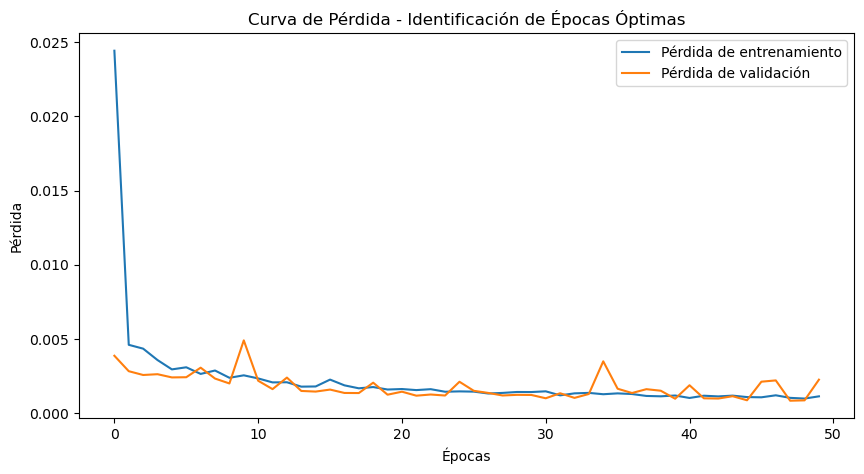

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
📉 RMSE del modelo Hybrid CNN + LSTM: 0.0475
💰 RMSE en dólares con Hybrid CNN + LSTM: $37.58
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 


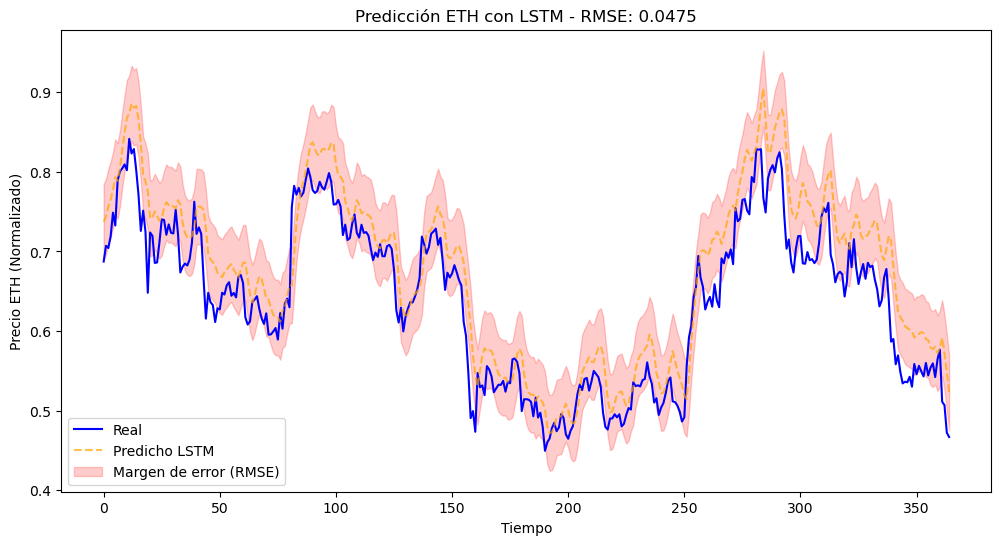

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos preprocesados y asegurarse de que no estén anidados
X_train = np.load("Dataset/X_train_eth.npy", allow_pickle=True)
X_test = np.load("Dataset/X_test_eth.npy", allow_pickle=True)
y_train = np.load("Dataset/y_train_eth.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_eth.npy", allow_pickle=True)

# 🔹 Eliminar la columna de fechas si existe
def remove_date_column(data):
    if isinstance(data, np.ndarray) and data.shape[-1] > 1:
        return data[:, 1:]  # Eliminar la primera columna (fecha)
    return data

X_train = remove_date_column(X_train)
X_test = remove_date_column(X_test)

# 🔹 Convertir cualquier valor Timestamp a numérico
def convert_timestamps(data):
    for i in range(data.shape[1]):
        if isinstance(data[0, i], pd.Timestamp):
            print(f"⚠️ Convirtiendo Timestamp en columna {i}")
            data[:, i] = [x.toordinal() if isinstance(x, pd.Timestamp) else x for x in data[:, i]]
    return data

X_train = convert_timestamps(X_train)
X_test = convert_timestamps(X_test)

# Asegurar que los datos sean numéricos
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# 🔹 Definir el modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# 🔹 Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 🔹 Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 🔹 Guardar el modelo entrenado
model.save("lstm_model_v1_eth.keras")
print("✅ Modelo LSTM guardado en lstm_model.keras")

# 🔹 Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida - Identificación de Épocas Óptimas')
plt.show()

# 🔹 Evaluación del modelo
loss_lstm = model.evaluate(X_test, y_test)
rmse_lstm = np.sqrt(loss_lstm)
print(f"📉 RMSE del modelo Hybrid CNN + LSTM: {rmse_lstm:.4f}")

# 🔹 Convertir RMSE normalizado a dólares usando MAD
eth_mad = np.median(np.abs(df_eth["Close"] - df_eth["Close"].median()))
rmse_dollars_lstm = rmse_lstm * eth_mad
print(f"💰 RMSE en dólares con Hybrid CNN + LSTM: ${rmse_dollars_lstm:.2f}")

# 🔹 Predicciones
y_pred_lstm = model.predict(X_test)

# 🔹 Gráfica de predicción vs. valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color='blue')
plt.plot(y_pred_lstm, label="Predicho LSTM", linestyle="dashed", color='orange', alpha=0.7)
plt.fill_between(range(len(y_test)), y_pred_lstm.flatten() - rmse_lstm, y_pred_lstm.flatten() + rmse_lstm, color='red', alpha=0.2, label="Margen de error (RMSE)")
plt.xlabel("Tiempo")
plt.ylabel("Precio ETH (Normalizado)")
plt.legend()
plt.title(f"Predicción ETH con LSTM - RMSE: {rmse_lstm:.4f}")
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 


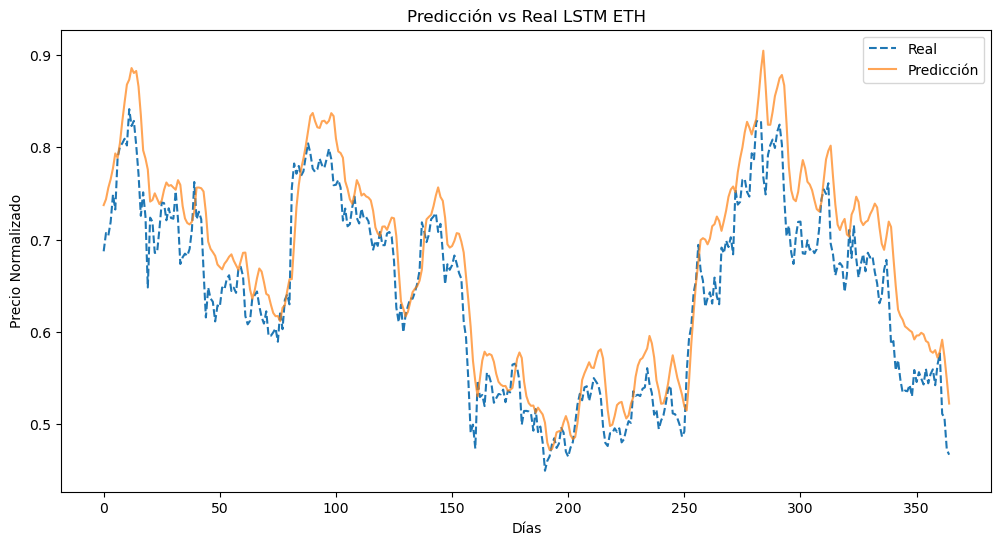

💰 RMSE en dólares: $250.92
📉 Error Cuadrático Medio (MSE): 0.0022520495660134678
📉 Raíz del Error Cuadrático Medio (RMSE): 0.047455764307547166


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# 🔹 Cargar los datasets para evaluar el modelo
X_test = np.load("Dataset/X_test_eth.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_eth.npy", allow_pickle=True)

# 🔹 Cargar el modelo entrenado
model = load_model("lstm_model_v1_eth.keras")

# 🔹 Hacer predicciones
y_pred = model.predict(X_test)

# 🔹 Desescalar los valores predichos y reales
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# 🔹 Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", linestyle='dashed')
plt.plot(y_pred, label="Predicción", alpha=0.7)
plt.legend()
plt.title("Predicción vs Real LSTM ETH")
plt.xlabel("Días")
plt.ylabel("Precio Normalizado")
plt.show()

# 🔹 Evaluar el modelo
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)

# 🔹 Obtener la desviación real del precio de BTC en el dataset
eth_price_std = np.std(y_pred) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * eth_price_std
print(f"💰 RMSE en dólares: ${rmse_dollars:.2f}")
print(f"📉 Error Cuadrático Medio (MSE): {mse}")
print(f"📉 Raíz del Error Cuadrático Medio (RMSE): {rmse}")